In [1]:
import pandas as pd
from IPython.display import display
import re
import numpy as np
from IPython.display import Image
import folium
from folium import plugins
from collections import Counter
import requests
import json
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import chisquare
from scipy import stats

In [2]:
results_df = pd.read_csv("../Resources/Accidental_Drug_Related_Deaths_2012-2017_cleaned.csv")
Counter(results_df["Race"])

Counter({'White': 3242,
         'Hispanic, White': 432,
         'Black': 329,
         'Unknown': 16,
         'Asian, Other': 14,
         nan: 9,
         'Hispanic, Black': 17,
         'Other': 7,
         'Asian Indian': 9,
         'Chinese': 2,
         'Native American, Other': 1,
         'Hawaiian': 1})

In [3]:
results_df["Race"] = results_df["Race"].replace(['Unknown','Asian Indian','Chinese','Native American, Other', 'Hawaiian'],'Other')
results_df['Race'] = results_df['Race'].fillna('Other')

In [4]:
race_counts = Counter(results_df["Race"])
race_counts

Counter({'White': 3242,
         'Hispanic, White': 432,
         'Black': 329,
         'Other': 45,
         'Asian, Other': 14,
         'Hispanic, Black': 17})

In [5]:
sex_counts = Counter(results_df["Sex"])
sex_counts

Counter({'Male': 2992, 'Female': 1085, nan: 2})

In [6]:
results_df["Age"].describe()

count    4078.000000
mean       41.755763
std        12.318326
min        14.000000
25%        31.000000
50%        42.000000
75%        52.000000
max        87.000000
Name: Age, dtype: float64

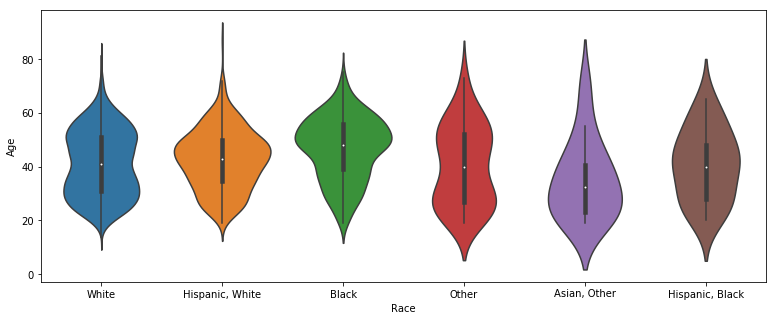

In [7]:
plt.figure(figsize=(13,5))
sns.violinplot(x="Race",y="Age",data=results_df)

plt.show()

In [8]:
age_groups = [0,19, 29,39,49,59,69,120]
age_grp_names = ["<=19years","20-29 years","30-39 years","40-49 years","50-59 years","60-69 years","70 years and older"]
results_df["Age Group"] = pd.cut(results_df["Age"],age_groups,labels=age_grp_names)


In [9]:
race_age_df = results_df.groupby(["Race","Age Group","Sex"])["CaseNumber"].count()
race_age_df.head()

Race          Age Group    Sex   
Asian, Other  <=19years    Male      1
              20-29 years  Male      5
              30-39 years  Female    3
                           Male      1
              40-49 years  Female    2
Name: CaseNumber, dtype: int64

In [10]:
race_df = results_df.groupby("Race")["CaseNumber"].count()
race_order = race_df.sort_values(ascending=False).index

In [11]:
bars_male=[]
for race in race_order:
    age_bins = []
    for age_bin in race_age_df.index.levels[1]:
        try:
            age_bins.append(race_age_df[(race,age_bin,"Male")])
        except:
            age_bins.append(0)
    bars_male.append(age_bins)
bars_male

[[25, 493, 642, 515, 511, 145, 10],
 [1, 47, 83, 128, 70, 18, 5],
 [0, 26, 45, 55, 81, 32, 4],
 [1, 10, 6, 5, 8, 3, 1],
 [0, 3, 3, 3, 3, 1, 0],
 [1, 5, 1, 0, 0, 0, 1]]

In [12]:
bars_female=[]
for race in race_order:
    age_bins = []
    for age_bin in race_age_df.index.levels[1]:
        try:
            age_bins.append(race_age_df[(race,age_bin,"Female")])
        except:
            age_bins.append(0)
    bars_female.append(age_bins)
bars_female

[[14, 178, 183, 220, 248, 47, 10],
 [0, 15, 18, 24, 16, 4, 1],
 [1, 7, 13, 32, 25, 7, 1],
 [1, 3, 1, 3, 3, 0, 0],
 [0, 2, 0, 2, 0, 0, 0],
 [0, 0, 3, 2, 1, 0, 0]]

In [13]:
stacking_bars_male = []
stacking_bars_male.append(list(np.zeros(len(age_grp_names))))
for i in range(1,len(bars_male)):
    age_bar = np.zeros(len(age_grp_names))
    for j in range(0,i):
        age_bar += np.array(bars_male[j])
    stacking_bars_male.append(list(age_bar))
stacking_bars_male

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [25.0, 493.0, 642.0, 515.0, 511.0, 145.0, 10.0],
 [26.0, 540.0, 725.0, 643.0, 581.0, 163.0, 15.0],
 [26.0, 566.0, 770.0, 698.0, 662.0, 195.0, 19.0],
 [27.0, 576.0, 776.0, 703.0, 670.0, 198.0, 20.0],
 [27.0, 579.0, 779.0, 706.0, 673.0, 199.0, 20.0]]

In [14]:
stacking_bars_female = []
stacking_bars_female.append(list(np.zeros(len(age_grp_names))))
for i in range(1,len(bars_female)):
    age_bar = np.zeros(len(age_grp_names))
    for j in range(0,i):
        age_bar += np.array(bars_female[j])
    stacking_bars_female.append(list(age_bar))
stacking_bars_female

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [14.0, 178.0, 183.0, 220.0, 248.0, 47.0, 10.0],
 [14.0, 193.0, 201.0, 244.0, 264.0, 51.0, 11.0],
 [15.0, 200.0, 214.0, 276.0, 289.0, 58.0, 12.0],
 [16.0, 203.0, 215.0, 279.0, 292.0, 58.0, 12.0],
 [16.0, 205.0, 215.0, 281.0, 292.0, 58.0, 12.0]]

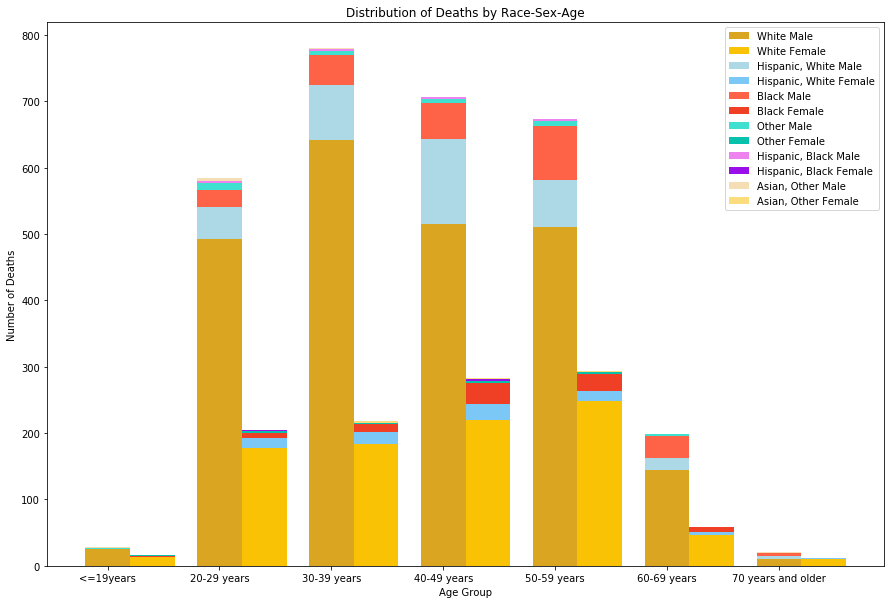

In [15]:
colors_list = ["goldenrod","lightblue","tomato","turquoise","violet","wheat", "sienna","plum","orchid"]

xticks = np.arange(1,len(age_groups))
plt.figure(figsize=(15,10))
w = 0.4
for i, race in enumerate(race_order):

    plt.bar(xticks,bars_male[i],bottom = stacking_bars_male[i],color=colors_list[i], label=race+" Male", width=w)
    plt.bar(xticks+w,bars_female[i],bottom = stacking_bars_female[i], color="xkcd:"+colors_list[i],\
            label=race+" Female", width=w)

plt.xticks(xticks, age_grp_names)
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.title("Distribution of Deaths by Race-Sex-Age")
plt.legend()
plt.show()

In [16]:
num_deaths_by_year = pd.DataFrame()
num_deaths_by_year["Total Deaths"]= results_df["Year"].value_counts()
num_deaths_by_year["Year Number"] = num_deaths_by_year.index - 2011
num_deaths_by_year

,Total Deaths,Year Number
2017,1038,6
2016,917,5
2015,723,4
2014,557,3
2013,489,2
2012,355,1


### Fitting linear regression:   
Independent variable: Year number   
Dependent variable : Number of deaths in that year  
Intercept = 193.33, Slope = 139  
###### Prediction for 2018 = 1166 deaths

In [17]:
regr = LinearRegression()

In [18]:
regr.fit(num_deaths_by_year[["Year Number"]],num_deaths_by_year[["Total Deaths"]] )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
regr.coef_, regr.intercept_, regr.predict(X=7)

(array([[139.]]), array([193.33333333]), array([[1166.33333333]]))

In [20]:
year_nums = range(1,7)
mortality_pred = regr.predict(num_deaths_by_year[["Year Number"]])
mortality_pred

array([[1027.33333333],
       [ 888.33333333],
       [ 749.33333333],
       [ 610.33333333],
       [ 471.33333333],
       [ 332.33333333]])

In [21]:
r2_score(num_deaths_by_year[["Total Deaths"]],mortality_pred, multioutput='variance_weighted')

0.9845688014710984

In [22]:
slope, intercept, r_value, p_value, std_err = stats.linregress(num_deaths_by_year["Year Number"],num_deaths_by_year["Total Deaths"])
r_value = "{0:.2f}".format(r_value)
p_value = "{0:.2e}".format(p_value)
print(slope, intercept, r_value, p_value, std_err)

139.0 193.33333333333337 0.99 8.98e-05 8.700848343969806


Text(2,700,'R^2 = 0.99\np-value = 8.98e-05')

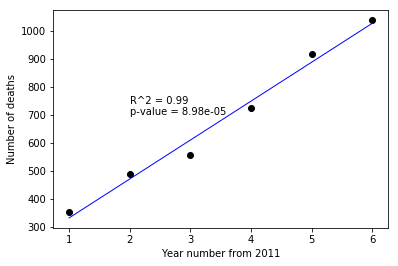

In [23]:
plt.scatter(num_deaths_by_year[["Year Number"]], num_deaths_by_year[["Total Deaths"]], color="black")
plt.plot(num_deaths_by_year[["Year Number"]], mortality_pred, color="blue", linewidth=1)
plt.xlabel("Year number from 2011")
plt.ylabel("Number of deaths")
plt.text(2,700,f"R^2 = {r_value}\np-value = {p_value}")

Get demographic data from census for age groups and race distribution.   
Chi-squared test for null-hypothesis:  
Null Hypothesis: Groups (age group in males or race group) are affected according to their proportion in population.  
Alternate Hypothesis: Some groups are disproportionately affected.  

Zero p-values indicate that we reject the null-hypothesis.

In [24]:
census_demographics = pd.read_csv("../Resources/DEC_10_DP_DPDP1_with_ann.csv").transpose()
census_demographics.head()


,0,1
GEO.id,Id,0400000US09
GEO.id2,Id2,09
GEO.display-label,Geography,Connecticut
HD01_S001,Number; SEX AND AGE - Total population,3574097
HD02_S001,Percent; SEX AND AGE - Total population,100.0


In [25]:
age_grp_names

['<=19years',
 '20-29 years',
 '30-39 years',
 '40-49 years',
 '50-59 years',
 '60-69 years',
 '70 years and older']

In [26]:
pat = re.compile("Percent; SEX AND AGE - Male population -")
for name in census_demographics.index:
    if pat.match(census_demographics.loc[name][0]):
        category = pat.sub("", census_demographics.loc[name][0])
        print(category,": ", census_demographics.loc[name][1])
                                                   
        

 Under 5 years :  2.9
 5 to 9 years :  3.2
 10 to 14 years :  3.4
 15 to 19 years :  3.6
 20 to 24 years :  3.3
 25 to 29 years :  3.0
 30 to 34 years :  2.9
 35 to 39 years :  3.0
 40 to 44 years :  3.6
 45 to 49 years :  4.0
 50 to 54 years :  3.9
 55 to 59 years :  3.3
 60 to 64 years :  2.7
 65 to 69 years :  2.0
 70 to 74 years :  1.3
 75 to 79 years :  1.1
 80 to 84 years :  0.8
 85 years and over :  0.8
 Median age (years) :   ( X ) 
 16 years and over :  38.4
 18 years and over :  37.0
 21 years and over :  34.9
 62 years and over :  7.5
 65 years and over :  6.0


In [27]:
male_dist_age_list = [ 3.3+3.0, 2.9+3.0, 3.6+4.0, 3.9+3.3, 2.7+2.0]
sum(male_dist_age_list)

31.699999999999996

In [28]:
male_distribution_age = np.array(male_dist_age_list)*100/sum(male_dist_age_list)
pprint(list(male_distribution_age))

[19.87381703470032,
 18.61198738170347,
 23.974763406940067,
 22.71293375394322,
 14.826498422712936]


In [29]:
results_df[results_df["Sex"]=="Male"]["Age Group"].value_counts()

30-39 years           780
40-49 years           706
50-59 years           673
20-29 years           584
60-69 years           199
<=19years              28
70 years and older     21
Name: Age Group, dtype: int64

In [30]:
male_mortality_per_age = [584, 780, 706, 673, 199]
print(sum(male_mortality_per_age))
exp_male_mortality_per_age = male_distribution_age * sum(male_mortality_per_age)/100
exp_male_mortality_per_age

2942


array([584.68769716, 547.56466877, 705.33753943, 668.21451104,
       436.1955836 ])

In [31]:
chisquare(male_mortality_per_age,exp_male_mortality_per_age)

Power_divergenceResult(statistic=227.6848482393274, pvalue=4.1587781107498485e-48)

In [32]:
pat = re.compile("Percent; HISPANIC OR LATINO AND RACE - Total population - ")
for name in census_demographics.index:
    if pat.match(census_demographics.loc[name][0]):
        category = pat.sub("", census_demographics.loc[name][0])
        print(category,": ", census_demographics.loc[name][1])

Hispanic or Latino :  13.4
Hispanic or Latino - White alone :  6.3
Hispanic or Latino - Black or African American alone :  0.8
Hispanic or Latino - American Indian and Alaska Native alone :  0.1
Hispanic or Latino - Asian alone :  0.0
Hispanic or Latino - Native Hawaiian and Other Pacific Islander alone :  0.0
Hispanic or Latino - Some Other Race alone :  5.2
Hispanic or Latino - Two or More Races :  0.9
Not Hispanic or Latino :  86.6
Not Hispanic or Latino - White alone :  71.2
Not Hispanic or Latino - Black or African American alone :  9.4
Not Hispanic or Latino - American Indian and Alaska Native alone :  0.2
Not Hispanic or Latino - Asian alone :  3.8
Not Hispanic or Latino - Native Hawaiian and Other Pacific Islander alone :  0.0
Not Hispanic or Latino - Some Other Race alone :  0.3
Not Hispanic or Latino - Two or More Races :  1.7


In [33]:
# Order is: White, hispanic white, black, hispanic black, asian, other
race_distribution = [71.2, 6.3, 9.4,  0.8, 3.8,8.5  ]
sum(race_distribution)

100.0

In [34]:
race_counts

Counter({'White': 3242,
         'Hispanic, White': 432,
         'Black': 329,
         'Other': 45,
         'Asian, Other': 14,
         'Hispanic, Black': 17})

In [35]:
race_mortality = [3242, 432, 329, 17, 14, 45]
sum(race_mortality)
np.set_printoptions(suppress=True)
exp_race_mortality = sum(race_mortality)*np.array(race_distribution)/100
exp_race_mortality

array([2904.248,  256.977,  383.426,   32.632,  155.002,  346.715])

In [36]:
chisquare(race_mortality, exp_race_mortality)

Power_divergenceResult(statistic=564.5205266785881, pvalue=9.344788590570142e-120)